# Ring filter design

In this notebook, we are going to design a ring-based wavelength filter to achieve an extinction ratio between two wavelengths of at least -50dB.
The material platform will be silicon nitride on insulator, and we are going to use strip waveguides to design all components.
We will be taking into account material dispersion as well as losses (both component and bend losses).

In [1]:
from collections import defaultdict
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import meep as mp
import numpy as np
import sax
from jax.config import config
from sax.typing_ import SDict
from scipy.constants import speed_of_light as c0
from tqdm import tqdm

import phodex.modes.femwell as pf
from phodex.materials import n_si3n4, n_sio2
from phodex.modes.mpb import find_singlemode_width

config.update("jax_enable_x64", True)

Using MPI version 4.0, 1 processes


/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


First, some basic parameters. Our operational wavelength will be 1550nm and we will use waveguides with a height of 300nm.

In [2]:
wavelength = 1.55
omega = 2 * np.pi / wavelength * c0
n_core = n_si3n4
n_clad = n_sio2
wvg_height = 0.3

## Waveguide design

The very first thing we need to do is design a single-mode waveguide for our material platform.
We will use `phodex`'s built-in `find_singlemode_width` function for this, which uses MPB under the hood and uses the approach detailed in the notebook on waveguide design.

In [3]:
k_points = mp.interpolate(50, [mp.Vector3(0.1), mp.Vector3(2.5)])
ks = np.array([k.x for k in k_points])
bracket = (0.5, 1.5)
geometry_lattice = mp.Lattice(size=mp.Vector3(0, 6 * bracket[-1], 6 * wvg_height))

singlemode_width = find_singlemode_width(
    wvg_height,
    wavelength,
    n_core(wavelength),
    n_clad(wavelength),
    resolution=20,
    k_points=k_points,
    k_vals=ks,
    lattice=geometry_lattice,
    bracket=bracket,
)

print(f"Minimum single-mode width: {singlemode_width:.5f}μm")

Minimum single-mode width: 1.15561μm


Great, so now we know that the waveguide needs to be at least 1.15μm wide for single-mode operation.
However, in this case we probably don't want to be right at the edge of the second-order band, as the waveguide should also maintain its single-mode properties for wavelengths slightly smaller than 1.55μm, so we will round down to 1μm.

In [4]:
wvg_width = 1.0

Now, let's calculate the effective index of our waveguide as well as its group index.
We won't actually need these values later, but they are always good to know!

In [5]:
straight = pf.bend_modes_box(
    wavelength, n_core, n_clad, wvg_width, wvg_height, radius=np.inf
)
straight["ng"] = pf.group_index(
    wavelength, n_core, n_clad, wvg_width, wvg_height, radius=np.inf
)

print(
    "Straight waveguide:\n"
    f' Effective index: {np.real(straight["lams"][0]):.5f}\n'
    f' Group index: {straight["ng"][0]:.5f}'
)

Straight waveguide:
 Effective index: 1.57610
 Group index: 1.94313


## Bent waveguide losses

We will model the resonator as a waveguide that is bent 360 degrees and coupled to a straight waveguide.
However, we are not actually going to model the straight waveguide - instead, we will model the straight section simply as a directional coupler with some insertion loss.

This means that the values that we are actually interested in are the effective index and the bend loss of the curved waveguide in the ring, as this is what we want to model accurately.

So first, we are going to perform a sweep over different bend radii to (roughly) identify a ring radius that should work for our purpose.

100%|██████████| 39/39 [01:16<00:00,  1.97s/it]


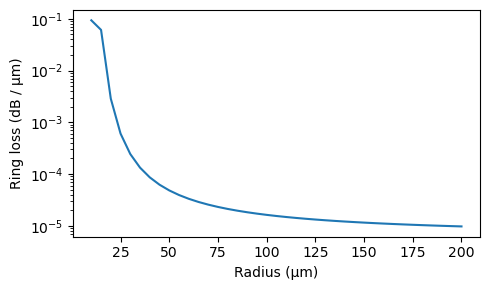

In [6]:
radii = np.linspace(10, 200, 39)
loss_db_mu = []
n_guess = straight["lams"][0]
for radius in tqdm(radii):
    mode = pf.bend_modes_box(
        wavelength,
        n_core,
        n_clad,
        wvg_width,
        wvg_height,
        radius=radius,
        n_guess=n_guess,
    )
    loss = np.abs(np.imag(mode["lams"][0]))
    loss_db_mu.append(-20 * np.log10(np.exp(-2 * np.pi * loss / wavelength)))
    n_guess = mode["lams"][0]

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(radii, loss_db_mu)
ax.set_ylabel("Ring loss (dB / μm)")
plt.setp(ax, xlabel="Radius (μm)", yscale="log")
fig.tight_layout()
plt.show()

The choice of radius is somewhat arbitrary, but it seems like the losses around 50μm are quite acceptable, and this way we won't need to blow up the size of the ring too much.
In terms of propagations losses, smaller rings are likely also better as the effects of surface roughness (which we don't model here) will contribute less to the overall loss.

Also note that this is only an initial radius, we will need to tweak this later anyways.

In [7]:
radius = 50

Now that we have a radius to work with, let's have a look at the relevant values.

In [8]:
bent = pf.bend_modes_box(
    wavelength, n_core, n_clad, wvg_width, wvg_height, radius, n_guess=n_guess
)
bent["ng"] = pf.group_index(wavelength, n_core, n_clad, wvg_width, wvg_height, radius)

ring50_loss = np.abs(np.imag(bent["lams"][0]))
ring50_loss_db = -20 * np.log10(np.exp(-2 * np.pi * loss / wavelength))

print(
    f"Ring ({radius} μm):\n"
    f' Effective index: {np.real(bent["lams"][0]):.5f}\n'
    f' Group index: {bent["ng"][0]:.5f}\n'
    f" Loss (dB/μm): {ring50_loss_db:.5e}"
)

Ring (50 μm):
 Effective index: 1.57684
 Group index: 1.94056
 Loss (dB/μm): 9.75750e-06


We can see that both the effective index and the group index are slightly different from the ones of the straight waveguide (obviously).
The loss is really small, and it's not too easy to judge how realistic this is in the end, so we'll add some more later just to be safe.

## Getting a dispersion relation

Next, we need a dispersion relation for the ring at different wavelengths, and we'll make one for the straight waveguide as well, just out of curiosity.
We do this simply by calculating the effective indices in the wavelength range of interest and then do a linear fit.
The linear fit is of course not valid in general but, as we will see, the wavelength range that we are looking at is small enough that the dispersion is pretty much perfectly linear here.

In [9]:
fit_wls = jnp.linspace(1.545, 1.555, 11)
res = defaultdict(list)
for wl in tqdm(fit_wls):
    res["neff_ring"].append(
        pf.effective_index(wl, n_core, n_clad, wvg_width, wvg_height, radius=radius)
    )
    res["neff_wvg"].append(
        pf.effective_index(wl, n_core, n_clad, wvg_width, wvg_height, radius=np.inf)
    )
res = {k: np.array(v) for k, v in res.items()}

/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


We define a function to create our dispersion relation and do a fit for the waveguide and ring values we calculated just above.

In [10]:
def make_neff(wls, neffs, order=1):
    p = jnp.polyfit(wls, neffs, order)

    def _neff(x):
        return jnp.polyval(p, x)

    return _neff


neff_wvg = make_neff(fit_wls, res["neff_wvg"])
neff_ring = make_neff(fit_wls, res["neff_ring"])

And let's quickly plot the dispersion relation.

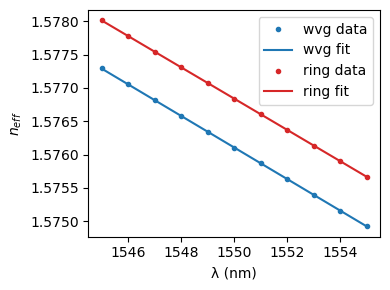

In [11]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(1000 * fit_wls, res["neff_wvg"], ".", c="tab:blue", label="wvg data")
ax.plot(1000 * fit_wls, neff_wvg(fit_wls), "-", c="tab:blue", label="wvg fit")
ax.plot(1000 * fit_wls, res["neff_ring"], ".", c="tab:red", label="ring data")
ax.plot(1000 * fit_wls, neff_ring(fit_wls), "-", c="tab:red", label="ring fit")
ax.set_xlabel("λ (nm)")
ax.set_ylabel("$n_{eff}$")
plt.legend()
fig.tight_layout()
plt.show()

We can see that the linear fit was a perfectly valid choice, and that the ring has a _slightly_ higher effective index than the straight waveguide.
As the difference in effective indices is pretty small here, we could have probably gotten away without considering dispersion.

## Circuit simulation

Now we have all the ingredients to create a circuit model for our ring resonator.
We will create a very basic circuit that consists only of a coupler and the ring itself, with the the option to add multiple non-interacting rings in sequence along the waveguide.
We will not consider rings made up of multiple sections (such as in racetrack resonators) or straight waveguide elements connecting all components.

First, we will define our two components - the ring and the coupler.
The ring is modeled simply as a lossy waveguide.
We will also add some loss to our coupler model, just to keep a semblance of realism.
We can then at least argue that losses in the sections connecting multiple rings are incorporated into the insertion loss of each coupler 😉.

In [12]:
def ring_maker(neff):
    def _model(*, wl: float = 1.55, radius: float = 100.0, loss: float = 0.0) -> SDict:
        k = 2 * jnp.pi * neff(wl) / wl
        L = 2 * jnp.pi * radius
        amplitude = 10 ** (-loss * L / 20)
        transmission = amplitude * jnp.exp(1j * k * L)
        return sax.utils.reciprocal({("in0", "out0"): transmission})

    return _model


def coupler(coupling: float = 0.5, loss_db: float = 0.0) -> SDict:
    loss = 10 ** (-loss_db / 10)
    kappa = jnp.sqrt(loss * coupling)
    tau = jnp.sqrt(loss * (1 - coupling))
    sdict = sax.utils.reciprocal(
        {
            ("in0", "out0"): tau,
            ("in0", "out1"): 1j * kappa,
            ("in1", "out0"): 1j * kappa,
            ("in1", "out1"): tau,
        }
    )
    return sdict

With these two components, we can now define our circuit model using [SAX](https://github.com/flaport/sax).
The only thing complicating things slightly here is that we need to keep track of the port and component indices when creating multiple rings.
The model as defined here directly returns the S-parameters of the circuit it's simulating.

In [13]:
@partial(jax.jit, static_argnames=["neff", "num_rings"])
def multiring(wl, radius, ring_loss, coupling, coupler_loss, neff, num_rings):
    ring = ring_maker(neff)
    instances = {}
    connections = {}
    for ii in range(num_rings):
        instances[f"dc{ii}"] = {
            "component": "coupler",
            "settings": {"coupling": coupling, "loss_db": coupler_loss},
        }
        instances[f"ring{ii}"] = {
            "component": "ring",
            "settings": {"radius": radius, "loss": ring_loss, "wl": wl},
        }
        connections[f"dc{ii},out1"] = f"ring{ii},in0"
        connections[f"ring{ii},out0"] = f"dc{ii},in1"

    for ii in range(num_rings - 1):
        connections[f"dc{ii},out0"] = f"dc{ii+1},in0"

    return sax.circuit(
        netlist={
            "instances": instances,
            "connections": connections,
            "ports": {"in0": "dc0,in0", "out0": f"dc{num_rings-1},out0"},
        },
        models={"coupler": coupler, "ring": ring},
    )[0]()

And now we are ready to do the inital ciruit simulation!
We will be adding some additional loss to the ring to account for things like surface roughness, and we will also give the coupler a small loss.
It should be noted that these values are pretty arbitrary.

We will be starting by setting the coupling coefficient to 0.5 (50/50 split) and visualize the transmission of the system for the case of a single ring and two rings.

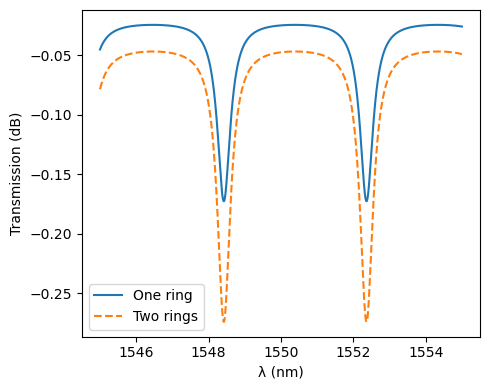

In [14]:
ring_loss = ring50_loss_db + 1e-5
coupler_loss = 0.02
coupling = 0.5
wl = jnp.linspace(1.545, 1.555, 10000)

det_single = multiring(wl, radius, ring_loss, coupling, coupler_loss, neff_ring, 1)
det_multi = multiring(wl, radius, loss, coupling, coupler_loss, neff_ring, 2)
t_single = jnp.abs(det_single["in0", "out0"]) ** 2
t_multi = jnp.abs(det_multi["in0", "out0"]) ** 2

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(wl * 1e3, 10 * np.log10(t_single), label="One ring")
ax.plot(wl * 1e3, 10 * np.log10(t_multi), "--", label="Two rings")
ax.set_xlabel("λ (nm)")
ax.set_ylabel("Transmission (dB)")
ax.legend()
fig.tight_layout()
plt.show()

Great, that looks like we at least set up our models properly!
Obviously we are still quite far away from a good design, as the extinction ratio is very low and the resonance is also not centered at our operational wavelength.

## Finding a good resonator design

### Shifting the resonance

The first thing we should do is shift the resonance of the filter to our wavelength of interest, i.e. 1.55μm.
The resonance is determined by the phase accumulated during each round trip through the ring, so we will need to tweak the ring radius.
The resonance condition for the optical path length difference follows $m \lambda_0 = 2 \pi r n_{eff}$, so we simply need to find the $m$ that yields a radius that is closest to our target radius of 50μm.

In [15]:
target_radius = 50
m = round(2 * jnp.pi * target_radius * neff_ring(1.55) / 1.55)
radius = m * 1.55 / (2 * jnp.pi * neff_ring(1.55))

print(f"Ring radius for resonance: {radius[0]:.5f}μm")

Ring radius for resonance: 50.06274μm


Let's visualize our circuit for this new radius!

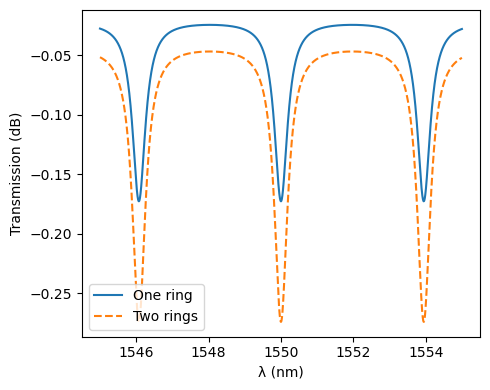

In [16]:
det_single = multiring(wl, radius, ring_loss, coupling, coupler_loss, neff_ring, 1)
det_multi = multiring(wl, radius, loss, coupling, coupler_loss, neff_ring, 2)
t_single = jnp.abs(det_single["in0", "out0"]) ** 2
t_multi = jnp.abs(det_multi["in0", "out0"]) ** 2

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(wl * 1e3, 10 * np.log10(t_single), label="One ring")
ax.plot(wl * 1e3, 10 * np.log10(t_multi), "--", label="Two rings")
ax.set_xlabel("λ (nm)")
ax.set_ylabel("Transmission (dB)")
ax.legend()
fig.tight_layout()
plt.show()

### Maximizing extinction

Now that we are on-resonance, we need to maximize the extinction ratio to actually create a good filter, which we will do by tweaking the coupling ratio of the coupler.
To do this, we will define a function that returns the extinction coefficient between two wavelengths.
The two wavelengths that we will pick here are the resonance wavelength (maximal absorption) and the wavelength in the middle of the free spectral range, where we have minimal absorption.

We'll first create a function that calculates the FSR from our known dispersion relation.

In [17]:
def make_fsr(wls, neffs, order=1):
    neff = make_neff(wls, neffs, order)
    p = jnp.polyfit(wls, neffs, order)
    dn = jnp.polyder(p, 1)

    def _fsr(r, wl):
        return wl**2 / (2 * jnp.pi * r) / (neff(wl) - wl * jnp.polyval(dn, wl))

    return _fsr


ring_fsr = make_fsr(fit_wls, res["neff_ring"])

We will now define our objective and finely sweep coupling values between 0 and 0.5 to identify the point of maximal extinction (spoiler alert: it will be the ratio where we get critical coupling).

Critical coupling for coupling = 0.00600


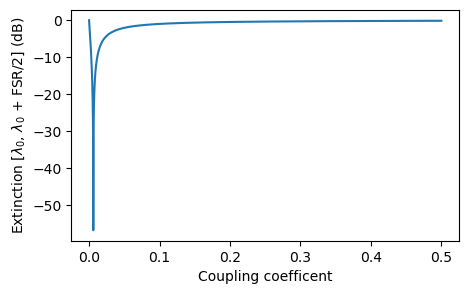

In [18]:
def objective_extinction(c, w0, dl, n):
    d0 = multiring(w0, radius, ring_loss, c, coupler_loss, neff_ring, n)
    d1 = multiring(w0 + dl, radius, ring_loss, c, coupler_loss, neff_ring, n)
    p0 = jnp.abs(d0["in0", "out0"]) ** 2
    p1 = jnp.abs(d1["in0", "out0"]) ** 2
    return 10 * jnp.log10(p0 / p1)


w0 = 1.55
dl = ring_fsr(radius, w0) / 2
c0 = jnp.linspace(0, 0.5, 10000)
c = objective_extinction(c0, w0, dl, 1)
critical_coupling = c0[jnp.argmin(c)]

print(f"Critical coupling for coupling = {critical_coupling:.5f}")

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(c0, c)
ax.set_xlabel("Coupling coefficent")
ax.set_ylabel("Extinction [$\lambda_0$, $\lambda_0$ + FSR/2] (dB)")
plt.show()

Great, we have identified the point of critical coupling and reach our 50dB extinction ratio goal with just a single ring.

Lastly, we can visualize the resonance.
As we are now in the critical coupling regime, the resonance peak will be extremly narrow, so we will need to sample very finely around a small wavelength range around the resonance.

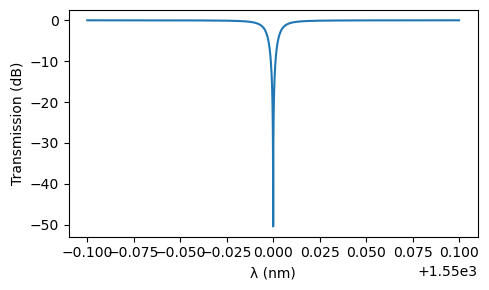

In [19]:
wl = jnp.linspace(1.5499, 1.5501, 10000)
det_single = multiring(
    wl, radius, ring_loss, critical_coupling, coupler_loss, neff_ring, 1
)
t_single = jnp.abs(det_single["in0", "out0"]) ** 2
t_multi = jnp.abs(det_multi["in0", "out0"]) ** 2

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(wl * 1e3, 10 * np.log10(t_single))
ax.set_xlabel("λ (nm)")
ax.set_ylabel("Transmission (dB)")
fig.tight_layout()
plt.show()